# MNIST Digit Classification
MNIST is the "hello world" of computer vision, so this project is for me to show off my computer vision skills on a widely known and straightforward dataset. Here's a rundown of the task:
- Classify a 28x28 pixel greyscale image of a handwritten digit into the class corresponding to its value {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
- Train on a set of 60,000 images, test on a set of 10,000

In [17]:
import numpy as np
import struct
from array import array
from os.path  import join
import torch
import torch.nn as nn
import random
import matplotlib.pyplot as plt

# Provided data loader found at https://www.kaggle.com/code/hojjatk/read-mnist-dataset
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img            
        
        return images, labels
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)  

## Loading the images

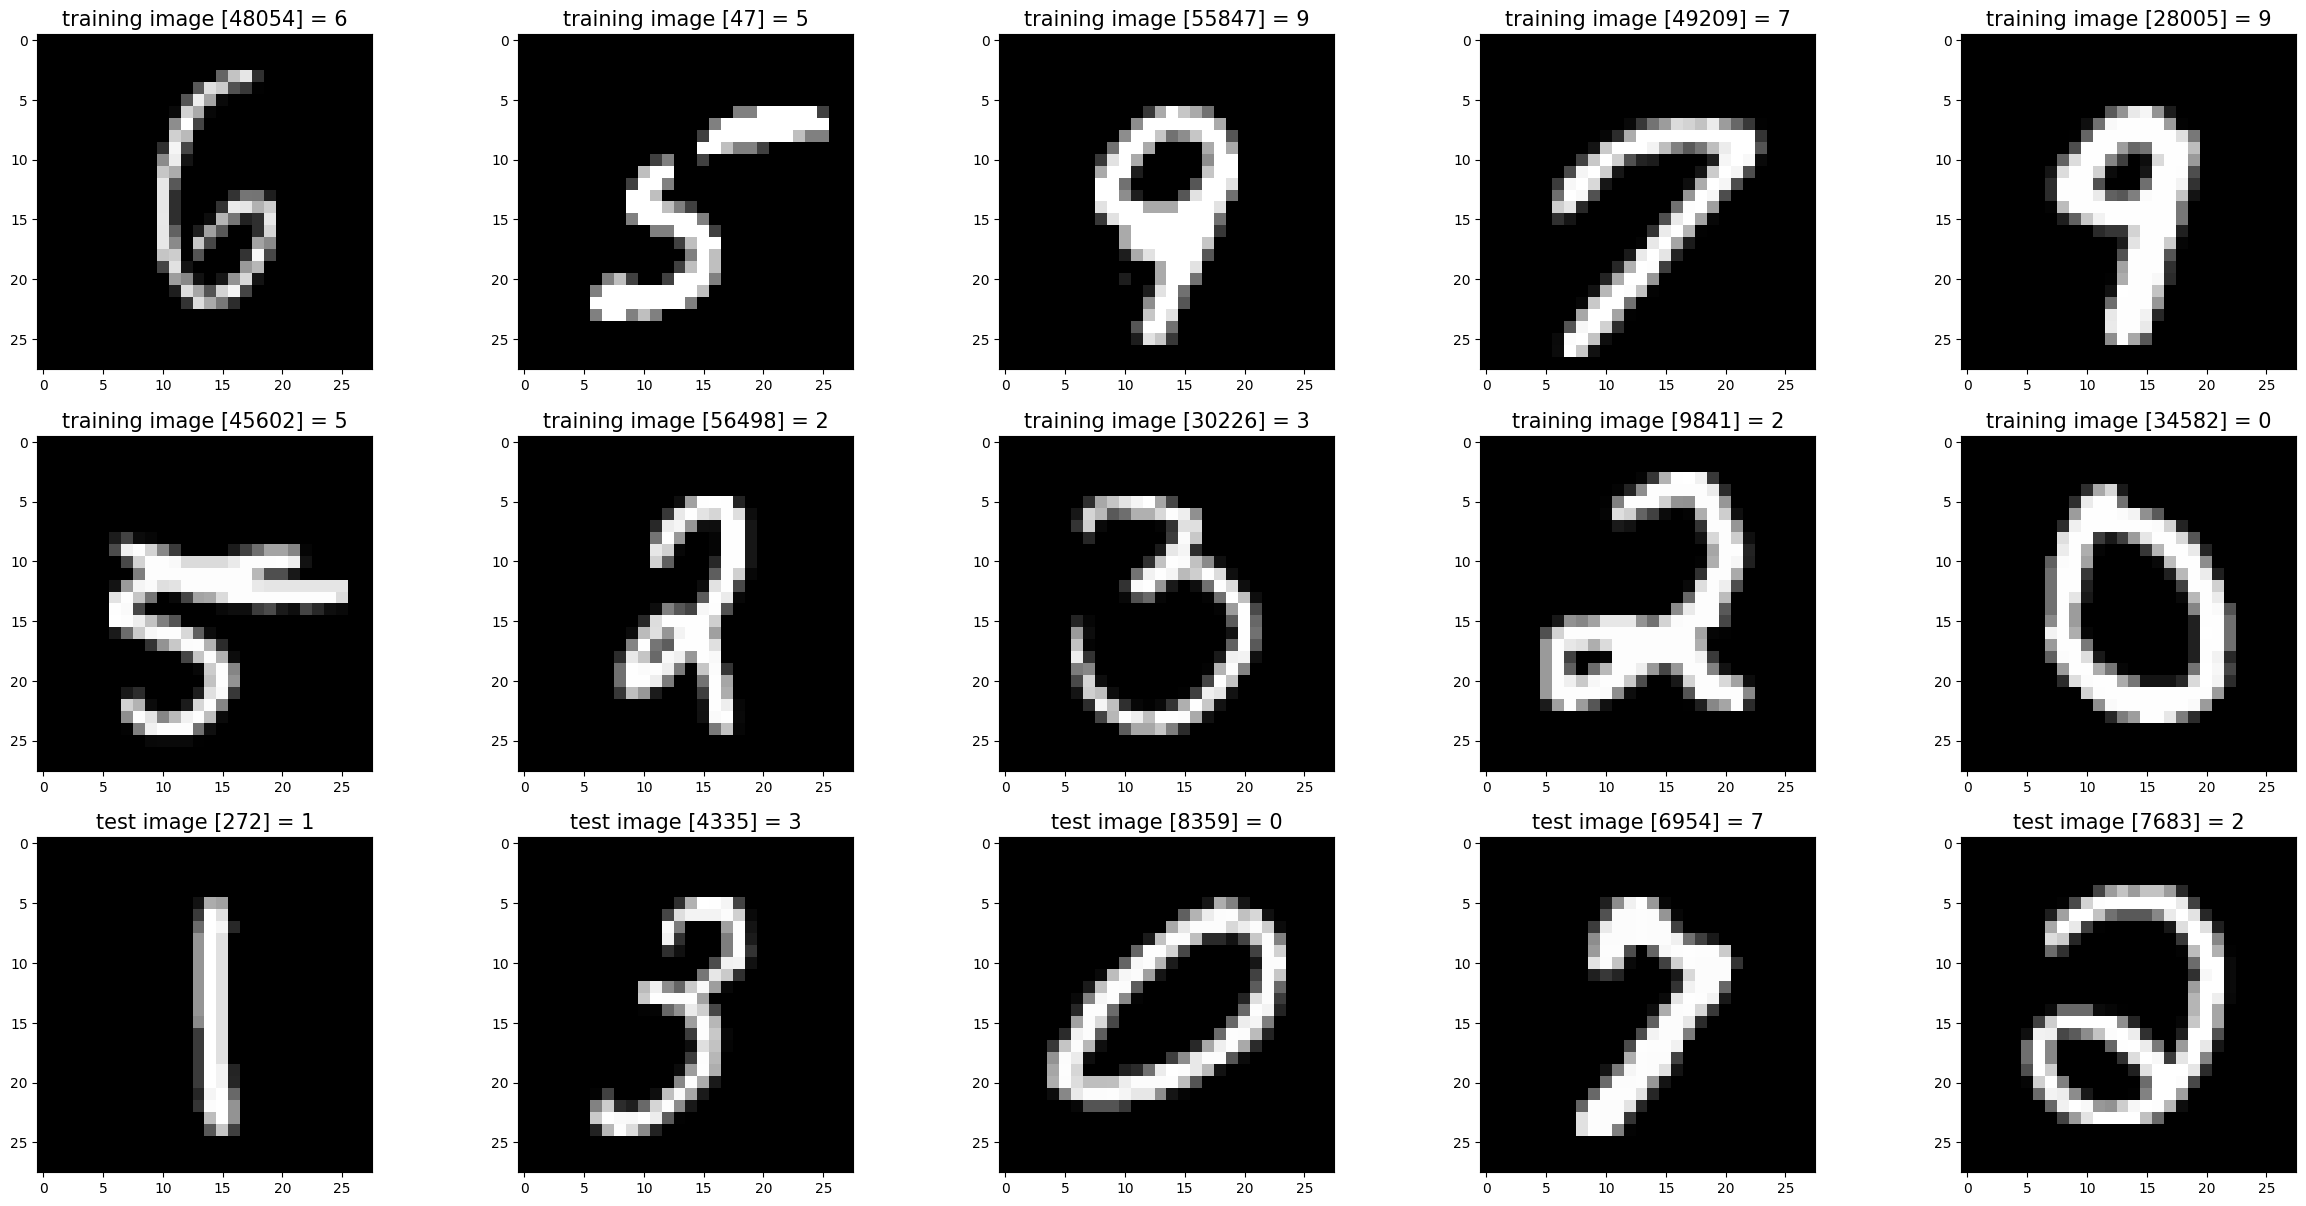

In [18]:
training_images_filepath = 'data/train-images.idx3-ubyte'
training_labels_filepath = 'data/train-labels.idx1-ubyte'
test_images_filepath = 'data/t10k-images.idx3-ubyte'
test_labels_filepath = 'data/t10k-labels.idx1-ubyte'

def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);        
        index += 1

mnist_dataloader = MnistDataloader(training_images_filepath,
                                   training_labels_filepath,
                                   test_images_filepath,
                                   test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

images_2_show = []
titles_2_show = []
for i in range(0, 10):
    r = random.randint(1, 60000)
    images_2_show.append(x_train[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(y_train[r]))    

for i in range(0, 5):
    r = random.randint(1, 10000)
    images_2_show.append(x_test[r])        
    titles_2_show.append('test image [' + str(r) + '] = ' + str(y_test[r]))    

show_images(images_2_show, titles_2_show)

## EDA
The MNIST dataset is well known and is accepted as clean, but for the sake of good practice, I run through a few checks just to make sure everything is in order. First up, I check out class distribution. If any one digit is significantly overrepresented, it may bias models during training. From the plots below, it looks like classes are fairly well distributed. One is slightly overrepresented in training data, but not to the point where I'm worried about it biasing the model towards it. After the plots I have some housekeeping checks to verify the count of training and test images (10,000 and 60,000 respectively) and to make sure that they're all 28x28 greyscale images. Finally, I do one last check just to make sure all of my labels are actually digits 0-9 and there's no sneaky letters or other characters in there. After all checks, it looks like the data is all good so it's time to get things ready for PyTorch.

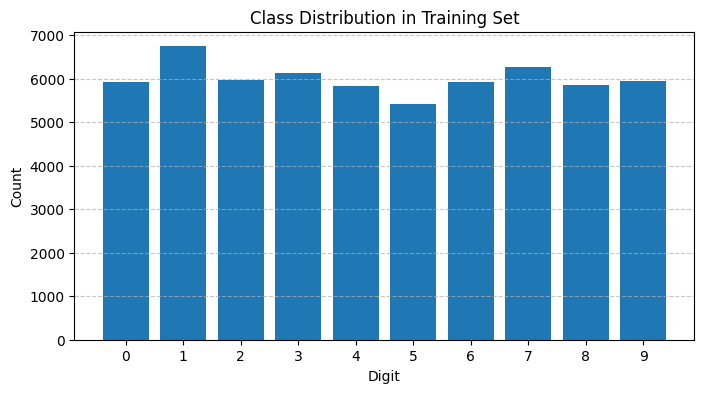

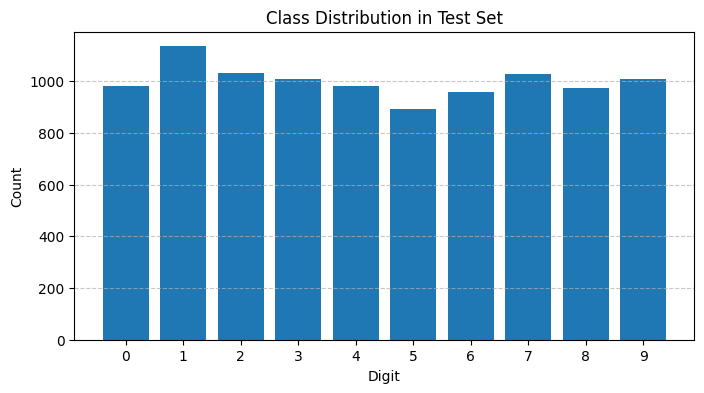

Training Set images shape: (60000, 28, 28)
Training Set dtype: uint8
All Training Set images are 28x28.
Pixel value range in Training Set: 0 to 255

Test Set images shape: (10000, 28, 28)
Test Set dtype: uint8
All Test Set images are 28x28.
Pixel value range in Test Set: 0 to 255

All Training Set labels are valid digits 0–9.
All Test Set labels are valid digits 0–9.


In [19]:
from collections import Counter

def plot_class_distribution(y_data, dataset_name):
    counter = Counter(y_data)
    labels, counts = zip(*sorted(counter.items()))
    
    plt.figure(figsize=(8, 4))
    plt.bar(labels, counts)
    plt.title(f'Class Distribution in {dataset_name}')
    plt.xlabel('Digit')
    plt.ylabel('Count')
    plt.xticks(labels)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

def check_images(images, dataset_name):
    images = np.array(images)  # Convert list to NumPy array if not already
    print(f'{dataset_name} images shape: {images.shape}')
    print(f'{dataset_name} dtype: {images.dtype}')
    
    unique_shapes = {img.shape for img in images}
    if unique_shapes == {(28, 28)}:
        print(f'All {dataset_name} images are 28x28.')
    else:
        print(f'Found images with shapes: {unique_shapes}')
    
    min_pixel = images.min()
    max_pixel = images.max()
    print(f'Pixel value range in {dataset_name}: {min_pixel} to {max_pixel}')
    print()

def check_labels(y_data, dataset_name):
    y_data = np.array(y_data)
    unique_labels = set(y_data)
    
    expected_labels = set(range(10))
    if unique_labels == expected_labels:
        print(f'All {dataset_name} labels are valid digits 0–9.')
    else:
        print(f'{dataset_name} labels contain unexpected values: {unique_labels}')


plot_class_distribution(y_train, 'Training Set')
plot_class_distribution(y_test, 'Test Set')

check_images(x_train, 'Training Set')
check_images(x_test, 'Test Set')

check_labels(y_train, 'Training Set')
check_labels(y_test, 'Test Set')

## Get data tensors ready
Since I'm using PyTorch, I need to get the data ready for use with PyTorch tensors so I can load them onto my GPU. I do this with very standard `Dataset` and `DataLoader` instances.
- Images reshape from `(28, 28)` to `(1, 28, 28)` for CNNs
- Pixel values normalized from `[0-255]` to `[0-1]`
- Labels cast to `torch.long` type for classification loss (will use `CrossEntropyLoss`)

Data loaders:
- Batch size 64 since image data is pretty small
- Train dataset shuffling each epoch is on to avoid order biasing
- Test dataset shuffling is off to keep it ordered for evaluation

In [20]:
from torch.utils.data import Dataset, DataLoader

class MNISTDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        # Convert image to float32 tensor and normalize to [0, 1]
        image = torch.tensor(image, dtype=torch.float32) / 255.0
        
        # Add channel dimension: (28,28) --> (1,28,28)
        image = image.unsqueeze(0)
        
        label = torch.tensor(label, dtype=torch.long)
        
        # Apply additional transform if provided
        if self.transform:
            image = self.transform(image)

        return image, label
    
train_dataset = MNISTDataset(x_train, y_train)
test_dataset = MNISTDataset(x_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

## Model building
I'll make three models for this task. My goal is to evaluate performance on this well understood task using a variety of CNN architectures. I'll start very basic with two convolution layers and scale up from there. My deeper model will use four convolution layers and my last model will mimic a VGG (Visual Geometry Group) CNN used for generally much higher performance requiring tasks. With the more complicated CNNs, I expect a bit of overfitting, so I'll need to include some regularization and maybe dropout.

| Feature | Simple CNN | Deeper CNN | Mini-VGG |
|:---|:---|:---|:---|
| # of Conv layers | 2 | 4 | 7 |
| Conv layer structure | 1 Conv ➔ ReLU ➔ Pool ➔ 1 Conv ➔ ReLU ➔ Pool | 2 Conv ➔ ReLU ➔ 2 Conv ➔ ReLU ➔ Pool (repeat) | (2 Conv ➔ Pool) ➔ (2 Conv ➔ Pool) ➔ (3 Conv ➔ Pool) |
| # of Dense layers | 2 (128, 10 units) | 2 (256, 10 units) | 2 (512, 10 units) |
| Expected overfitting | Low | Medium | High (needs dropout) |
| Suitable for | Quick baseline model | Learning deeper feature hierarchies | Practicing real-world deep model patterns |
| Regularization needed? | No (optional) | Maybe (batchnorm helps) | Yes (batchnorm + dropout to avoid overfitting) |


### Simple CNN Model
This will be the simplest CNN model that I train. It will have the following architecture:
- Conv block 1: Conv layer (32 filters, 3x3 kernel) ➔ ReLU ➔ Max Pool (2 stride)
- Conv block 2: Conv layer (64 filters, 3x3 kernel) ➔ ReLU ➔ Max Pool (2 stride)
- Fully connected 1: Dense layer (128 units) ➔ ReLU
- Fully connected 2: Output layer (10 units - one per digit)

In [21]:
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        
        # First convolutional layer
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Second convolutional layer
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        
        # Fully connected layers
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # 7x7 is size after two poolings from 28x28
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Conv1 ➔ ReLU ➔ Pool
        x = self.pool(F.relu(self.conv2(x)))  # Conv2 ➔ ReLU ➔ Pool
        x = x.view(x.size(0), -1)             # Flatten
        x = F.relu(self.fc1(x))                # FC1 ➔ ReLU
        x = self.fc2(x)                        # FC2 (output layer)
        return x

### Deeper CNN Model
This will be the middle model in terms of complexity that I train. It will have the following architecture:
- Conv Block 1: Conv layer (32 filters, 3x3 kernel) ➔ Conv layer (32 filters, 3x3 kernel) ➔ ReLU ➔ Max Pool (2 stride)
- Conv Block 2: Conv layer (64 filters, 3x3 kernel) ➔ Conv layer (64 filters, 3x3 kernel) ➔ ReLU ➔ Max Pool (2 stride)
- Fully connected 1: Dense layer (256 units) ➔ ReLU
- Fully connected 2:  Output layer (10 units - one per digit)

In [22]:
class DeeperCNN(nn.Module):
    def __init__(self):
        super(DeeperCNN, self).__init__()
        
        # First conv block
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        
        # Second conv block
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        
        # Max pooling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Fully connected layers
        self.fc1 = nn.Linear(64 * 7 * 7, 256)  # After two poolings: 28→14→7
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        # First conv block
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        
        # Second conv block
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

## Mini VGG Model
This will be the most complex model I train with hopefully the best performance (at risk of overfitting). It will have the following architecture:
- Conv Block 1: Conv layer (64 filters, 3×3 kernel) ➔ ReLU ➔ Conv layer (64 filters, 3×3 kernel) ➔ ReLU ➔ MaxPool2d(2 stride)
- Conv Block 2: Conv layer (128 filters, 3×3 kernel) ➔ ReLU ➔ Conv layer (128 filters, 3×3 kernel) ➔ ReLU ➔ MaxPool2d(2 stride)
- Conv Block 3: Conv layer (256 filters, 3×3 kernel) ➔ ReLU ➔ Conv layer (256 filters, 3×3 kernel) ➔ ReLU ➔ Conv2d(256 filters, 3×3 kernel) ➔ ReLU ➔ MaxPool2d(2 stride)
- Fully Connected 1	Dense (512 units) ➔ ReLU ➔ Dropout(0.5) to hopefully avoid overfitting
- Fully Connected 2	Dense (10 units- again, one per digit)

I'm adding this after the fact, but I also have batch normalization after every conv layer.


In [23]:
class MiniVGG(nn.Module):
    def __init__(self):
        super(MiniVGG, self).__init__()
        
        # First conv block
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        # Second conv block
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        
        # Third conv block
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        self.conv6 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(256)
        self.conv7 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.bn7 = nn.BatchNorm2d(256)
        
        # Pooling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Fully connected layers
        self.fc1 = nn.Linear(256 * 3 * 3, 512)  # After three poolings from 28x28
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        # First conv block
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        
        # Second conv block
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool(x)
        
        # Third conv block
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = F.relu(self.bn7(self.conv7(x)))
        x = self.pool(x)
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

## Model training
Now that I've got my models, it's time for the training loop. Because this is a classification task, I'll use `nn.CrossEntropyLoss`. For my optimizer I'll use an Adam optimizer. I'll also use a learning rate scheduler to I'll monitor training progress using tensorboard.

In [27]:
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm

def train_model(model, train_loader, test_loader, 
                num_epochs=10, learning_rate=0.001, device='cuda', 
                scheduler_step_size=5, scheduler_gamma=0.5, 
                log_dir='runs/mnist_experiment'):
    
    # Move model to device (cuda)
    model = model.to(device)
    
    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Define learning rate scheduler
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_step_size, gamma=scheduler_gamma)
    
    # Set up TensorBoard writer
    writer = SummaryWriter(log_dir=log_dir)
    
    global_step = 0
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in tqdm(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Log training loss every batch
            writer.add_scalar('Loss/train_batch', loss.item(), global_step)
            global_step += 1
        
        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total
        
        # Evaluation phase
        model.eval()
        running_loss_test = 0.0
        correct_test = 0
        total_test = 0
        
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss_test += loss.item()
                
                _, predicted = torch.max(outputs.data, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()
        
        test_loss = running_loss_test / len(test_loader)
        test_accuracy = 100 * correct_test / total_test
        
        # Step the learning rate scheduler
        scheduler.step()
        
        # TensorBoard logging for epoch summary
        writer.add_scalar('Loss/train_epoch', train_loss, epoch)
        writer.add_scalar('Loss/test_epoch', test_loss, epoch)
        writer.add_scalar('Accuracy/train_epoch', train_accuracy, epoch)
        writer.add_scalar('Accuracy/test_epoch', test_accuracy, epoch)
        writer.add_scalar('Learning_rate', scheduler.get_last_lr()[0], epoch)
        
        print(f'Epoch [{epoch+1}/{num_epochs}] - '
              f'Train Loss: {train_loss:.4f} - '
              f'Train Acc: {train_accuracy:.2f}% - '
              f'Test Loss: {test_loss:.4f} - '
              f'Test Acc: {test_accuracy:.2f}% - '
              f'LR: {scheduler.get_last_lr()[0]:.6f}')
    
    # Close TensorBoard writer
    writer.close()
    print('Training complete.')

## Run Training Loop
I check that CUDA is working before running and if it is, I run all of my models on my RTX 3090. After each model is trained, I clear my GPU's VRAM using `toch.cuda.empty_cache()` just to avoid clogging it up.

In [28]:
simpleCNN = SimpleCNN()
deeperCNN = DeeperCNN()
miniVGG = MiniVGG()

device = 'cuda' if torch.cuda.is_available() else 'cpu'

if device == 'cuda':
    print('Using GPU:', torch.cuda.get_device_name(0))
else:
    print('Using CPU')

print('Training Simple CNN Model')
train_model(simpleCNN, train_loader, test_loader,
            num_epochs=20, 
            learning_rate=0.001,
            device=device,
            scheduler_step_size=5,  # Decrease LR every 5 epochs
            scheduler_gamma=0.5,    # Halve the LR each step
            log_dir='runs/simplecnn_mnist')

torch.cuda.empty_cache()

print('Training Deeper CNN Model')
train_model(deeperCNN, train_loader, test_loader,
            num_epochs=20, 
            learning_rate=0.001,
            device=device,
            scheduler_step_size=5,  # Decrease LR every 5 epochs
            scheduler_gamma=0.5,    # Halve the LR each step
            log_dir='runs/deepercnn_mnist')

torch.cuda.empty_cache()

print('Training Mini-VGG Model')

train_model(miniVGG, train_loader, test_loader,
            num_epochs=20, 
            learning_rate=0.001,
            device=device,
            scheduler_step_size=5,  # Decrease LR every 5 epochs
            scheduler_gamma=0.5,    # Halve the LR each step
            log_dir='runs/minivgg_mnist')

Using GPU: NVIDIA GeForce RTX 3090
Training Simple CNN Model


100%|██████████| 938/938 [00:07<00:00, 133.42it/s]


Epoch [1/20] - Train Loss: 0.1830 - Train Acc: 94.52% - Test Loss: 0.0538 - Test Acc: 98.26% - LR: 0.001000


100%|██████████| 938/938 [00:08<00:00, 112.54it/s]


Epoch [2/20] - Train Loss: 0.0527 - Train Acc: 98.34% - Test Loss: 0.0370 - Test Acc: 98.80% - LR: 0.001000


100%|██████████| 938/938 [00:08<00:00, 115.41it/s]


Epoch [3/20] - Train Loss: 0.0348 - Train Acc: 98.89% - Test Loss: 0.0327 - Test Acc: 98.85% - LR: 0.001000


100%|██████████| 938/938 [00:08<00:00, 116.28it/s]


Epoch [4/20] - Train Loss: 0.0268 - Train Acc: 99.14% - Test Loss: 0.0297 - Test Acc: 98.89% - LR: 0.001000


100%|██████████| 938/938 [00:08<00:00, 116.57it/s]


Epoch [5/20] - Train Loss: 0.0211 - Train Acc: 99.32% - Test Loss: 0.0341 - Test Acc: 98.91% - LR: 0.000500


100%|██████████| 938/938 [00:07<00:00, 117.49it/s]


Epoch [6/20] - Train Loss: 0.0092 - Train Acc: 99.71% - Test Loss: 0.0241 - Test Acc: 99.30% - LR: 0.000500


100%|██████████| 938/938 [00:07<00:00, 117.69it/s]


Epoch [7/20] - Train Loss: 0.0067 - Train Acc: 99.80% - Test Loss: 0.0273 - Test Acc: 99.10% - LR: 0.000500


100%|██████████| 938/938 [00:07<00:00, 117.95it/s]


Epoch [8/20] - Train Loss: 0.0056 - Train Acc: 99.84% - Test Loss: 0.0320 - Test Acc: 99.11% - LR: 0.000500


100%|██████████| 938/938 [00:07<00:00, 118.63it/s]


Epoch [9/20] - Train Loss: 0.0048 - Train Acc: 99.86% - Test Loss: 0.0313 - Test Acc: 99.16% - LR: 0.000500


100%|██████████| 938/938 [00:08<00:00, 116.21it/s]


Epoch [10/20] - Train Loss: 0.0043 - Train Acc: 99.86% - Test Loss: 0.0352 - Test Acc: 99.08% - LR: 0.000250


100%|██████████| 938/938 [00:08<00:00, 116.72it/s]


Epoch [11/20] - Train Loss: 0.0016 - Train Acc: 99.96% - Test Loss: 0.0321 - Test Acc: 99.17% - LR: 0.000250


100%|██████████| 938/938 [00:08<00:00, 116.25it/s]


Epoch [12/20] - Train Loss: 0.0006 - Train Acc: 99.99% - Test Loss: 0.0320 - Test Acc: 99.27% - LR: 0.000250


100%|██████████| 938/938 [00:08<00:00, 116.56it/s]


Epoch [13/20] - Train Loss: 0.0004 - Train Acc: 100.00% - Test Loss: 0.0343 - Test Acc: 99.27% - LR: 0.000250


100%|██████████| 938/938 [00:08<00:00, 116.64it/s]


Epoch [14/20] - Train Loss: 0.0011 - Train Acc: 99.97% - Test Loss: 0.0361 - Test Acc: 99.18% - LR: 0.000250


100%|██████████| 938/938 [00:08<00:00, 116.11it/s]


Epoch [15/20] - Train Loss: 0.0008 - Train Acc: 99.99% - Test Loss: 0.0348 - Test Acc: 99.24% - LR: 0.000125


100%|██████████| 938/938 [00:08<00:00, 116.07it/s]


Epoch [16/20] - Train Loss: 0.0002 - Train Acc: 100.00% - Test Loss: 0.0348 - Test Acc: 99.24% - LR: 0.000125


100%|██████████| 938/938 [00:08<00:00, 111.58it/s]


Epoch [17/20] - Train Loss: 0.0001 - Train Acc: 100.00% - Test Loss: 0.0359 - Test Acc: 99.27% - LR: 0.000125


100%|██████████| 938/938 [00:08<00:00, 115.80it/s]


Epoch [18/20] - Train Loss: 0.0001 - Train Acc: 100.00% - Test Loss: 0.0377 - Test Acc: 99.23% - LR: 0.000125


100%|██████████| 938/938 [00:08<00:00, 115.45it/s]


Epoch [19/20] - Train Loss: 0.0001 - Train Acc: 100.00% - Test Loss: 0.0381 - Test Acc: 99.28% - LR: 0.000125


100%|██████████| 938/938 [00:08<00:00, 116.17it/s]


Epoch [20/20] - Train Loss: 0.0001 - Train Acc: 100.00% - Test Loss: 0.0391 - Test Acc: 99.29% - LR: 0.000063
Training complete.
Training 


100%|██████████| 938/938 [00:08<00:00, 109.08it/s]


Epoch [1/20] - Train Loss: 0.1453 - Train Acc: 95.33% - Test Loss: 0.0418 - Test Acc: 98.83% - LR: 0.001000


100%|██████████| 938/938 [00:08<00:00, 116.88it/s]


Epoch [2/20] - Train Loss: 0.0409 - Train Acc: 98.75% - Test Loss: 0.0299 - Test Acc: 99.00% - LR: 0.001000


100%|██████████| 938/938 [00:08<00:00, 112.36it/s]


Epoch [3/20] - Train Loss: 0.0276 - Train Acc: 99.16% - Test Loss: 0.0293 - Test Acc: 99.12% - LR: 0.001000


100%|██████████| 938/938 [00:08<00:00, 115.37it/s]


Epoch [4/20] - Train Loss: 0.0190 - Train Acc: 99.38% - Test Loss: 0.0320 - Test Acc: 99.10% - LR: 0.001000


100%|██████████| 938/938 [00:08<00:00, 116.26it/s]


Epoch [5/20] - Train Loss: 0.0164 - Train Acc: 99.45% - Test Loss: 0.0305 - Test Acc: 99.03% - LR: 0.000500


100%|██████████| 938/938 [00:08<00:00, 115.51it/s]


Epoch [6/20] - Train Loss: 0.0062 - Train Acc: 99.80% - Test Loss: 0.0213 - Test Acc: 99.34% - LR: 0.000500


100%|██████████| 938/938 [00:08<00:00, 116.77it/s]


Epoch [7/20] - Train Loss: 0.0031 - Train Acc: 99.92% - Test Loss: 0.0269 - Test Acc: 99.28% - LR: 0.000500


100%|██████████| 938/938 [00:07<00:00, 124.52it/s]


Epoch [8/20] - Train Loss: 0.0044 - Train Acc: 99.85% - Test Loss: 0.0311 - Test Acc: 99.29% - LR: 0.000500


100%|██████████| 938/938 [00:07<00:00, 124.88it/s]


Epoch [9/20] - Train Loss: 0.0039 - Train Acc: 99.87% - Test Loss: 0.0282 - Test Acc: 99.27% - LR: 0.000500


100%|██████████| 938/938 [00:07<00:00, 122.65it/s]


Epoch [10/20] - Train Loss: 0.0028 - Train Acc: 99.91% - Test Loss: 0.0283 - Test Acc: 99.26% - LR: 0.000250


100%|██████████| 938/938 [00:07<00:00, 119.52it/s]


Epoch [11/20] - Train Loss: 0.0005 - Train Acc: 99.98% - Test Loss: 0.0287 - Test Acc: 99.45% - LR: 0.000250


100%|██████████| 938/938 [00:07<00:00, 120.56it/s]


Epoch [12/20] - Train Loss: 0.0001 - Train Acc: 100.00% - Test Loss: 0.0328 - Test Acc: 99.38% - LR: 0.000250


100%|██████████| 938/938 [00:07<00:00, 119.12it/s]


Epoch [13/20] - Train Loss: 0.0000 - Train Acc: 100.00% - Test Loss: 0.0346 - Test Acc: 99.36% - LR: 0.000250


100%|██████████| 938/938 [00:07<00:00, 120.77it/s]


Epoch [14/20] - Train Loss: 0.0000 - Train Acc: 100.00% - Test Loss: 0.0365 - Test Acc: 99.37% - LR: 0.000250


100%|██████████| 938/938 [00:07<00:00, 121.26it/s]


Epoch [15/20] - Train Loss: 0.0000 - Train Acc: 100.00% - Test Loss: 0.0383 - Test Acc: 99.38% - LR: 0.000125


100%|██████████| 938/938 [00:07<00:00, 120.81it/s]


Epoch [16/20] - Train Loss: 0.0000 - Train Acc: 100.00% - Test Loss: 0.0394 - Test Acc: 99.39% - LR: 0.000125


100%|██████████| 938/938 [00:07<00:00, 122.22it/s]


Epoch [17/20] - Train Loss: 0.0000 - Train Acc: 100.00% - Test Loss: 0.0409 - Test Acc: 99.40% - LR: 0.000125


100%|██████████| 938/938 [00:07<00:00, 124.45it/s]


Epoch [18/20] - Train Loss: 0.0000 - Train Acc: 100.00% - Test Loss: 0.0425 - Test Acc: 99.38% - LR: 0.000125


100%|██████████| 938/938 [00:07<00:00, 121.65it/s]


Epoch [19/20] - Train Loss: 0.0000 - Train Acc: 100.00% - Test Loss: 0.0440 - Test Acc: 99.40% - LR: 0.000125


100%|██████████| 938/938 [00:07<00:00, 119.45it/s]


Epoch [20/20] - Train Loss: 0.0000 - Train Acc: 100.00% - Test Loss: 0.0459 - Test Acc: 99.40% - LR: 0.000063
Training complete.


100%|██████████| 938/938 [00:15<00:00, 61.95it/s]


Epoch [1/20] - Train Loss: 0.1262 - Train Acc: 96.15% - Test Loss: 0.0304 - Test Acc: 99.08% - LR: 0.001000


100%|██████████| 938/938 [00:14<00:00, 62.84it/s]


Epoch [2/20] - Train Loss: 0.0490 - Train Acc: 98.60% - Test Loss: 0.0235 - Test Acc: 99.26% - LR: 0.001000


100%|██████████| 938/938 [00:15<00:00, 60.41it/s]


Epoch [3/20] - Train Loss: 0.0359 - Train Acc: 98.99% - Test Loss: 0.0222 - Test Acc: 99.33% - LR: 0.001000


100%|██████████| 938/938 [00:14<00:00, 64.38it/s]


Epoch [4/20] - Train Loss: 0.0317 - Train Acc: 99.11% - Test Loss: 0.0331 - Test Acc: 99.10% - LR: 0.001000


100%|██████████| 938/938 [00:13<00:00, 68.59it/s]


Epoch [5/20] - Train Loss: 0.0259 - Train Acc: 99.25% - Test Loss: 0.0189 - Test Acc: 99.46% - LR: 0.000500


100%|██████████| 938/938 [00:14<00:00, 65.63it/s]


Epoch [6/20] - Train Loss: 0.0122 - Train Acc: 99.65% - Test Loss: 0.0221 - Test Acc: 99.34% - LR: 0.000500


100%|██████████| 938/938 [00:14<00:00, 65.07it/s]


Epoch [7/20] - Train Loss: 0.0109 - Train Acc: 99.69% - Test Loss: 0.0262 - Test Acc: 99.28% - LR: 0.000500


100%|██████████| 938/938 [00:15<00:00, 60.10it/s]


Epoch [8/20] - Train Loss: 0.0116 - Train Acc: 99.62% - Test Loss: 0.0221 - Test Acc: 99.45% - LR: 0.000500


100%|██████████| 938/938 [00:15<00:00, 60.55it/s]


Epoch [9/20] - Train Loss: 0.0093 - Train Acc: 99.72% - Test Loss: 0.0206 - Test Acc: 99.49% - LR: 0.000500


100%|██████████| 938/938 [00:15<00:00, 62.33it/s]


Epoch [10/20] - Train Loss: 0.0094 - Train Acc: 99.71% - Test Loss: 0.0223 - Test Acc: 99.43% - LR: 0.000250


100%|██████████| 938/938 [00:14<00:00, 63.84it/s]


Epoch [11/20] - Train Loss: 0.0038 - Train Acc: 99.89% - Test Loss: 0.0184 - Test Acc: 99.58% - LR: 0.000250


100%|██████████| 938/938 [00:15<00:00, 60.05it/s]


Epoch [12/20] - Train Loss: 0.0023 - Train Acc: 99.93% - Test Loss: 0.0250 - Test Acc: 99.50% - LR: 0.000250


100%|██████████| 938/938 [00:13<00:00, 69.22it/s]


Epoch [13/20] - Train Loss: 0.0030 - Train Acc: 99.91% - Test Loss: 0.0215 - Test Acc: 99.54% - LR: 0.000250


100%|██████████| 938/938 [00:15<00:00, 60.75it/s]


Epoch [14/20] - Train Loss: 0.0033 - Train Acc: 99.91% - Test Loss: 0.0236 - Test Acc: 99.58% - LR: 0.000250


100%|██████████| 938/938 [00:15<00:00, 61.47it/s]


Epoch [15/20] - Train Loss: 0.0018 - Train Acc: 99.95% - Test Loss: 0.0250 - Test Acc: 99.54% - LR: 0.000125


100%|██████████| 938/938 [00:15<00:00, 60.62it/s]


Epoch [16/20] - Train Loss: 0.0011 - Train Acc: 99.97% - Test Loss: 0.0233 - Test Acc: 99.59% - LR: 0.000125


100%|██████████| 938/938 [00:15<00:00, 60.20it/s]


Epoch [17/20] - Train Loss: 0.0005 - Train Acc: 99.98% - Test Loss: 0.0232 - Test Acc: 99.62% - LR: 0.000125


100%|██████████| 938/938 [00:15<00:00, 61.80it/s]


Epoch [18/20] - Train Loss: 0.0005 - Train Acc: 99.98% - Test Loss: 0.0297 - Test Acc: 99.55% - LR: 0.000125


100%|██████████| 938/938 [00:15<00:00, 60.88it/s]


Epoch [19/20] - Train Loss: 0.0006 - Train Acc: 99.98% - Test Loss: 0.0358 - Test Acc: 99.44% - LR: 0.000125


100%|██████████| 938/938 [00:13<00:00, 70.68it/s]


Epoch [20/20] - Train Loss: 0.0003 - Train Acc: 99.99% - Test Loss: 0.0323 - Test Acc: 99.55% - LR: 0.000063
Training complete.


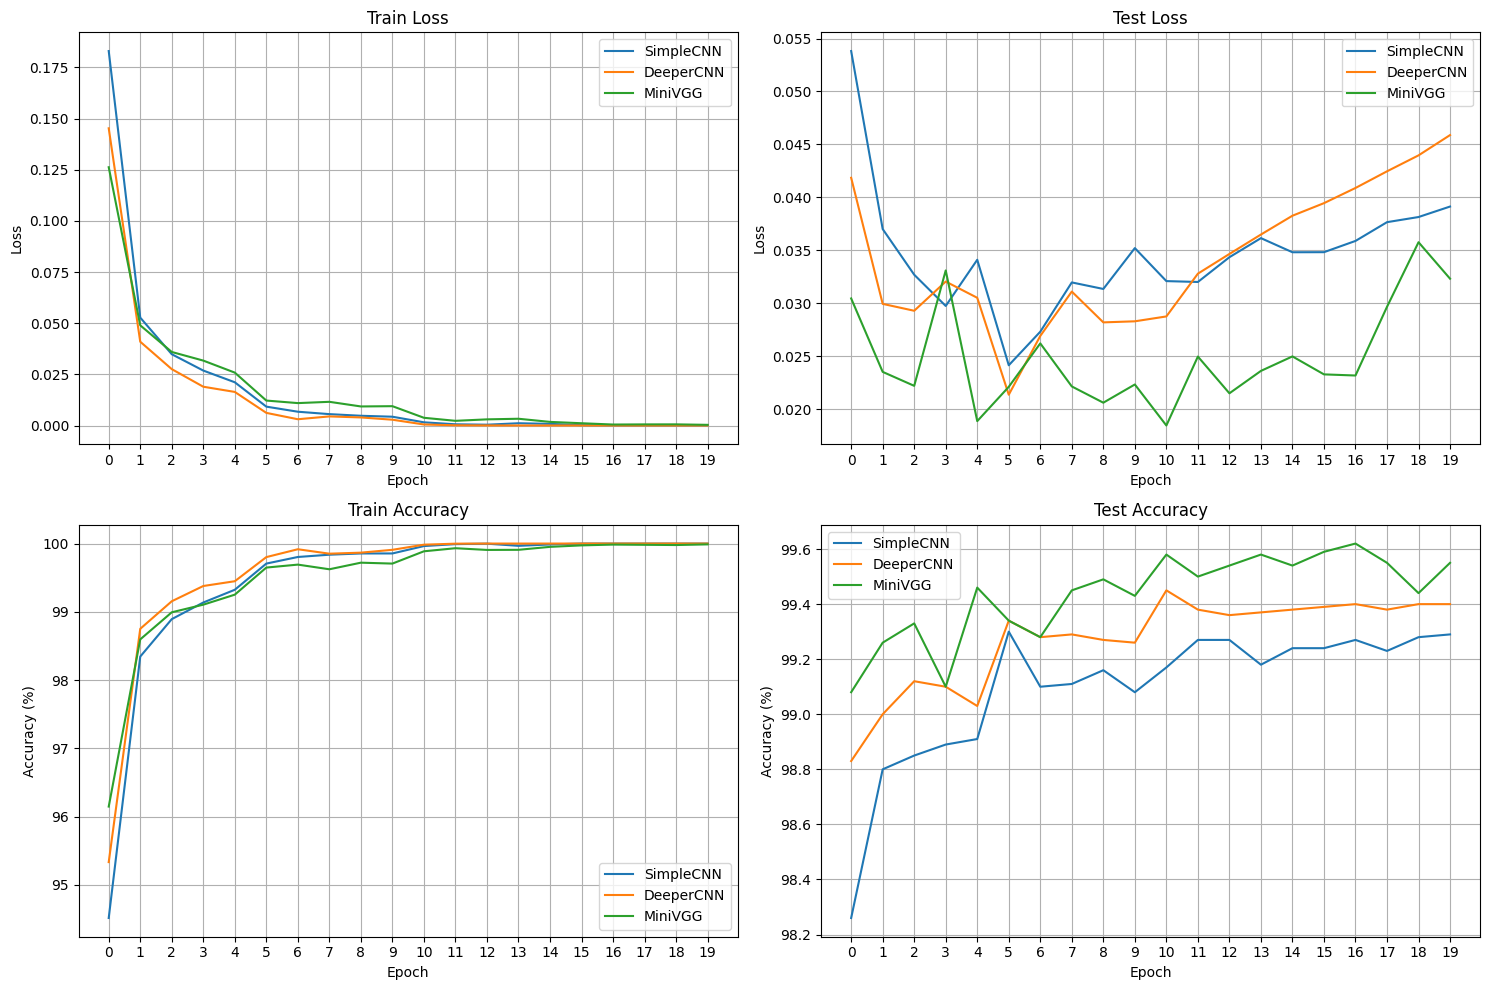

In [35]:
from tensorboard.backend.event_processing import event_accumulator
from matplotlib.ticker import MultipleLocator

# Helper function to load event data
def load_scalars(log_dir, tag):
    ea = event_accumulator.EventAccumulator(log_dir)
    ea.Reload()
    scalars = ea.Scalars(tag)
    steps = [s.step for s in scalars]
    values = [s.value for s in scalars]
    return steps, values


log_dirs = {
    'SimpleCNN': 'runs/simplecnn_mnist',
    'DeeperCNN': 'runs/deepercnn_mnist',
    'MiniVGG': 'runs/minivgg_mnist'
}

# Plotting
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot Loss (Train)
for model_name, log_dir in log_dirs.items():
    steps, values = load_scalars(log_dir, 'Loss/train_epoch')
    axes[0, 0].plot(steps, values, label=model_name)
axes[0, 0].set_title('Train Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)
axes[0, 0].xaxis.set_major_locator(MultipleLocator(1))

# Plot Loss (Test)
for model_name, log_dir in log_dirs.items():
    steps, values = load_scalars(log_dir, 'Loss/test_epoch')
    axes[0, 1].plot(steps, values, label=model_name)
axes[0, 1].set_title('Test Loss')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True)
axes[0, 1].xaxis.set_major_locator(MultipleLocator(1))

# Plot Accuracy (Train)
for model_name, log_dir in log_dirs.items():
    steps, values = load_scalars(log_dir, 'Accuracy/train_epoch')
    axes[1, 0].plot(steps, values, label=model_name)
axes[1, 0].set_title('Train Accuracy')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Accuracy (%)')
axes[1, 0].legend()
axes[1, 0].grid(True)
axes[1, 0].xaxis.set_major_locator(MultipleLocator(1))

# Plot Accuracy (Test)
for model_name, log_dir in log_dirs.items():
    steps, values = load_scalars(log_dir, 'Accuracy/test_epoch')
    axes[1, 1].plot(steps, values, label=model_name)
axes[1, 1].set_title('Test Accuracy')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Accuracy (%)')
axes[1, 1].legend()
axes[1, 1].grid(True)
axes[1, 1].xaxis.set_major_locator(MultipleLocator(1))

plt.tight_layout()
plt.show()

In [36]:
def evaluate_model(model, test_loader, device='cpu'):
    model = model.to(device)
    model.eval()
    
    correct = 0
    total = 0
    
    misclassified = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Find misclassified indices
            mismatch = predicted != labels
            for img, true_label, pred_label in zip(inputs[mismatch], labels[mismatch], predicted[mismatch]):
                    misclassified.append((img.cpu(), true_label.cpu(), pred_label.cpu()))

    accuracy = 100 * correct / total
    
    return accuracy, misclassified

models = {
    'SimpleCNN': simpleCNN,
    'DeeperCNN': deeperCNN,
    'Mini-VGG': miniVGG
}

print('Final Evaluation Report:\n')

final_results = {}

for model_name, model in models.items():
    accuracy, misclassified = evaluate_model(model, test_loader, device=device)

    final_results[model_name] = {
         'accuracy': accuracy,
         'misclassified': misclassified
    }

    print(f'{model_name}:')
    print(f'  Test Accuracy: {accuracy:.2f}%')
    print(f'  Misclassified Samples: {len(misclassified)}\n')


Final Evaluation Report:

SimpleCNN:
  Test Accuracy: 99.29%
  Misclassified Samples: 71

DeeperCNN:
  Test Accuracy: 99.40%
  Misclassified Samples: 60

Mini-VGG:
  Test Accuracy: 99.55%
  Misclassified Samples: 45



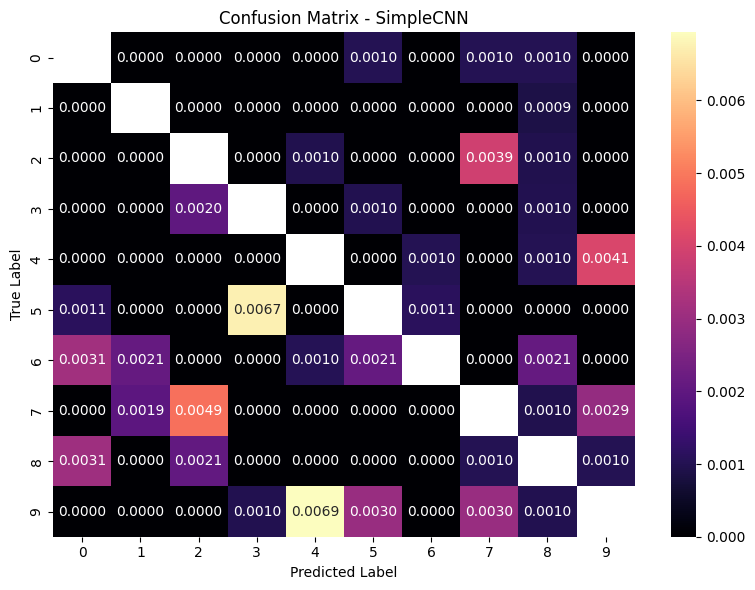

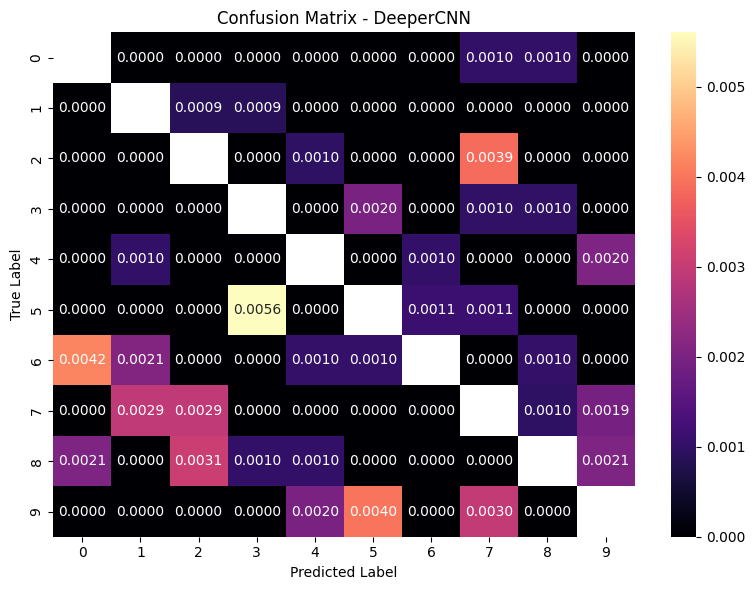

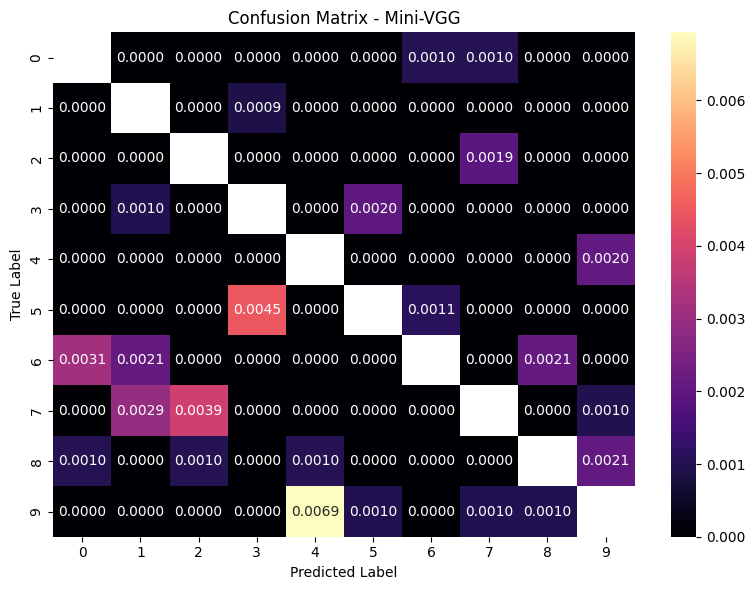

SimpleCNN Miss #1: Predicted 7, True 8
SimpleCNN Miss #2: Predicted 4, True 9
SimpleCNN Miss #3: Predicted 8, True 1
SimpleCNN Miss #4: Predicted 5, True 6
SimpleCNN Miss #5: Predicted 3, True 5
SimpleCNN Miss #6: Predicted 2, True 7
SimpleCNN Miss #7: Predicted 4, True 9
SimpleCNN Miss #8: Predicted 0, True 6


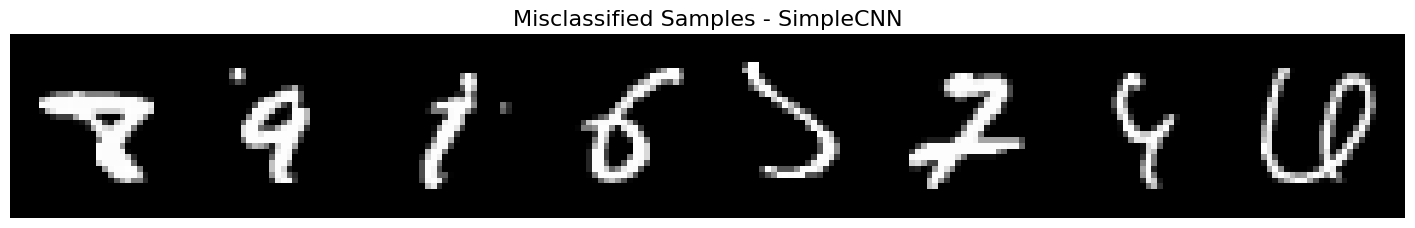

DeeperCNN Miss #1: Predicted 7, True 9
DeeperCNN Miss #2: Predicted 0, True 6
DeeperCNN Miss #3: Predicted 0, True 8
DeeperCNN Miss #4: Predicted 5, True 3
DeeperCNN Miss #5: Predicted 0, True 6
DeeperCNN Miss #6: Predicted 2, True 8
DeeperCNN Miss #7: Predicted 9, True 4
DeeperCNN Miss #8: Predicted 0, True 8


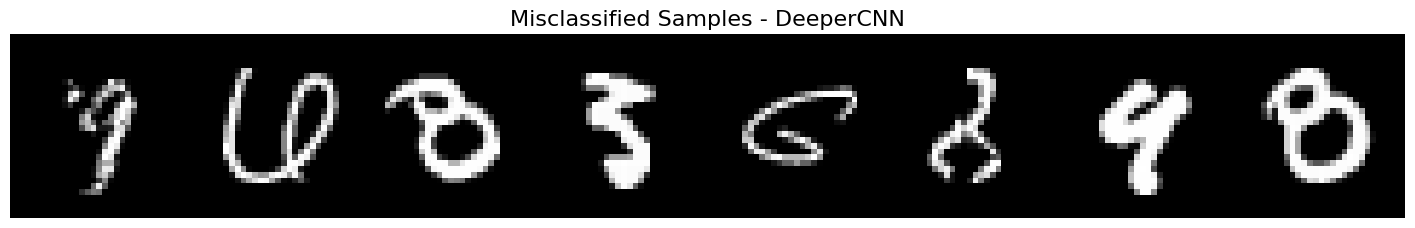

Mini-VGG Miss #1: Predicted 2, True 7
Mini-VGG Miss #2: Predicted 1, True 6
Mini-VGG Miss #3: Predicted 1, True 7
Mini-VGG Miss #4: Predicted 2, True 7
Mini-VGG Miss #5: Predicted 9, True 8
Mini-VGG Miss #6: Predicted 4, True 8
Mini-VGG Miss #7: Predicted 3, True 5
Mini-VGG Miss #8: Predicted 2, True 7


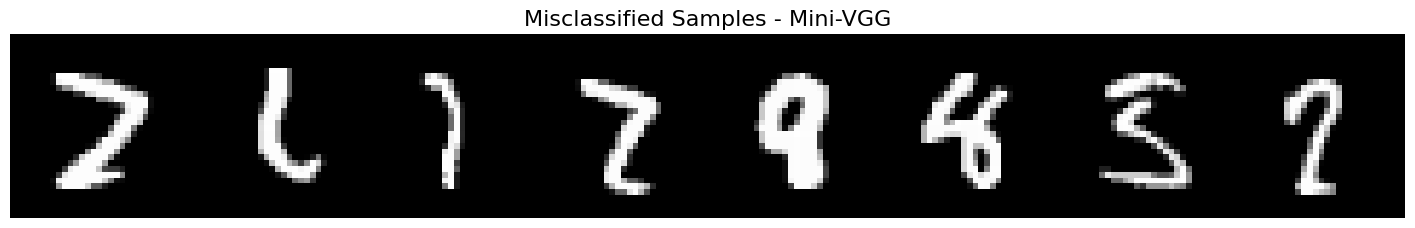

In [41]:
from torchvision.utils import make_grid
import torchvision.transforms.functional as TF
from sklearn.metrics import confusion_matrix
import seaborn as sns

def compute_confusion_matrix(model, test_loader, device='cpu'):
    model = model.to(device)
    model.eval()
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return confusion_matrix(all_labels, all_preds)

def plot_confusion_matrix(cm, model_name, normalize=True):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1, keepdims=True)
    
    plot_matrix = cm.copy()
    np.fill_diagonal(plot_matrix, np.nan) # Ignore diagonals to highlight misses

    plt.figure(figsize=(8, 6))
    sns.heatmap(plot_matrix, annot=True, fmt=".4f" if normalize else "d", cmap='magma', 
                xticklabels=list(range(10)), yticklabels=list(range(10)))
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

def show_random_misclassified(final_results, n_samples=8):
    for model_name, result in final_results.items():
        misses = result['misclassified']
        if len(misses) < n_samples:
            print(f"{model_name} has only {len(misses)} misclassified samples.")
            samples = misses
        else:
            samples = random.sample(misses, n_samples)

        # Extract image tensors, predicted and true labels
        images = [img for img, true, pred in samples]
        true_labels = [true.item() for img, true, pred in samples]
        pred_labels = [pred.item() for img, true, pred in samples]

        # Create grid (1 channel grayscale → replicate to 3 for visibility)
        images_rgb = [img.repeat(3, 1, 1) for img in images]  # shape (3, 28, 28)
        grid = make_grid(images_rgb, nrow=n_samples, padding=2)

        # Plot
        plt.figure(figsize=(18, 3))
        plt.imshow(grid.permute(1, 2, 0))  # (C, H, W) → (H, W, C)
        plt.axis('off')
        plt.title(f'Misclassified Samples - {model_name}', fontsize=16)

        # Show per-image annotations
        for i in range(n_samples):
            print(f"{model_name} Miss #{i+1}: Predicted {pred_labels[i]}, True {true_labels[i]}")

        plt.show()

for name, model in models.items():
    cm = compute_confusion_matrix(model, test_loader, device=device)
    plot_confusion_matrix(cm, name, normalize=True)

show_random_misclassified(final_results, n_samples=8)